In [593]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

In [594]:
def load_images():
    image_names = os.listdir("test_images")
    images_arr = []
    np.random.seed(0)
    for image_name in image_names:
        julian_date = float(".".join(image_name.split(".")[0:2]))
        image = np.array(Image.open(f"test_images/{image_name}")).astype(np.float32)
        # image = np.array(Image.open(f"test_images/{image_names[0]}")).astype(np.float32)
        # # Create output image
        images_arr.append((julian_date, image))

    for i in range(1):
        images_arr = images_arr + images_arr
    return images_arr

def get_timesteps(images_arr):
    timesteps = [image[0] for image in images_arr]
    # simulate uneven sampling
    timesteps = list([np.random.randint(0, len(timesteps)) for _ in range(len(timesteps))])
    timesteps.sort()
    return timesteps


In [595]:
def pad_around_point(image, point_y, point_x, pad_size, mean=70, std=15, sigma=1.0):
    result = image.copy()
    height, width = image.shape
    
    y_start = max(0, point_y - pad_size)
    y_end = min(height, point_y + pad_size + 1)
    x_start = max(0, point_x - pad_size)
    x_end = min(width, point_x + pad_size + 1)
    
    # Create coordinate grids
    y_coords = np.arange(y_start, y_end)
    x_coords = np.arange(x_start, x_end)
    x_grid, y_grid = np.meshgrid(x_coords - point_x, y_coords - point_y)
    
    # Calculate Gaussian values centered at the mean with desired std
    gaussian = np.random.normal(mean, std, size=(y_end-y_start, x_end-x_start))
    
    # Apply spatial Gaussian falloff
    spatial_gaussian = np.exp(-(x_grid**2 + y_grid**2)/(2*sigma**2))
    
    # Combine the random Gaussian noise with the spatial Gaussian falloff
    final_values = gaussian * spatial_gaussian
    
    # Add values around the point
    result[y_start:y_end, x_start:x_end] = final_values

    return result


In [596]:
def simulate_point_linear_source(image, position, velocity, time, fill=67):
    image_copy = image.copy()
    # simulate weird nonlinear motion
    new_position = position + velocity * time * np.sqrt(time) * time
    new_position = new_position.astype(int)
    # image_copy[new_position[0], new_position[1]] = fill

    # spread signal out to neighboring pixels
    image_copy = pad_around_point(image_copy, new_position[1], new_position[0], 1)

    # noise = np.random.normal(0, 15.8, image_copy.shape)
    # image_copy = image_copy + noise
    # image_copy = np.clip(image_copy, 0, 130)
    image_copy = image_copy.astype(np.uint8)
    return image_copy, new_position

trajectory = []

def moving_source_gif(images, position, velocity, timesteps):
    timeseries = []
    for i in range(len(timesteps)):
        simulated_image, new_position = simulate_point_linear_source(images[i], position, velocity, timesteps[i])
        trajectory.append(new_position)
        timeseries.append(simulated_image)
    timeseries_gif = [Image.fromarray(image.astype(np.uint8), mode='L').convert('RGB') for image in timeseries]
    timeseries_gif[0].save(
        'animated_moving_source.gif',
        save_all=True,
        append_images=timeseries_gif[1:],
        optimize=False,
        duration=100,
        loop=0
    )

    return np.array(timeseries)


In [597]:
image_time_pairs = load_images()
timesteps = get_timesteps(image_time_pairs)
images = [image[1] for image in image_time_pairs]

data = moving_source_gif(images, np.array([100, 100]), np.array([0.01, 0.03]), timesteps)

In [598]:
def apply_wavelet_transform(data, wavelet):
    coeffs = pywt.dwtn(data, wavelet)
    return coeffs

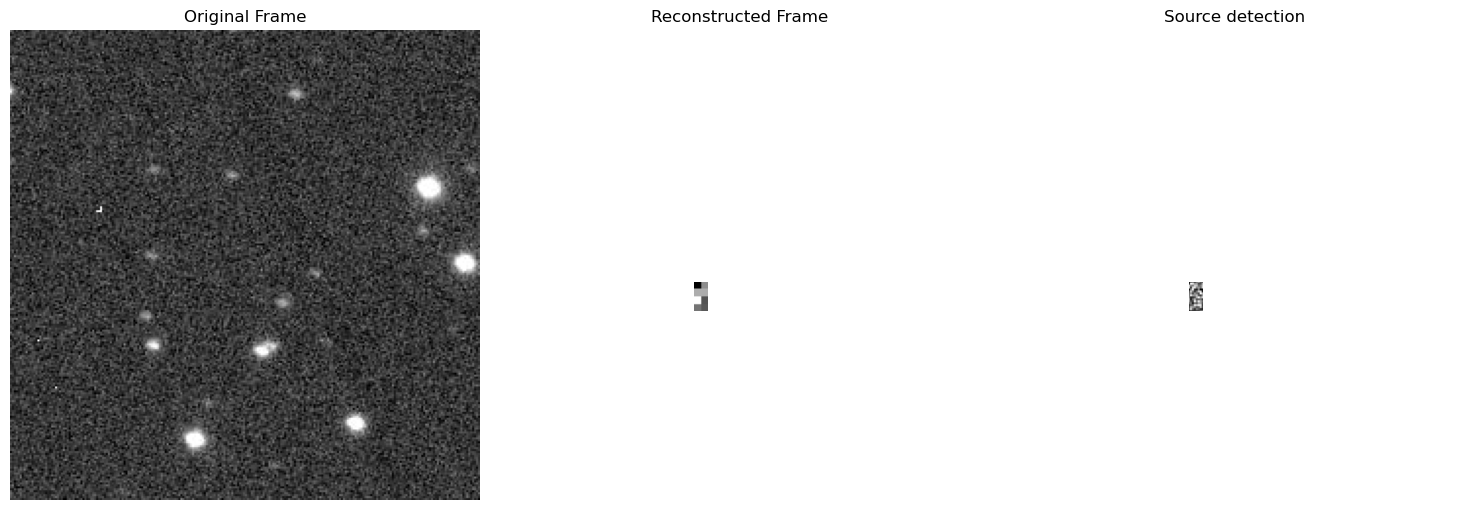

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Assuming 'data' is your 3D numpy array (time x height x width)
# data = ...

# Parameters
num_frames = data.shape[0]
height = data.shape[1]
width = data.shape[2]

wavelet = 'db1'

# Perform n-dimensional wavelet decomposition using wavedecn
coeffs = pywt.wavedecn(data, wavelet=wavelet)

# Initialize a list to hold the thresholded coefficients
coeffs_thresholded = [coeffs[0]]  # Do not threshold the approximation coefficients

# Loop over each level starting from level 1
for i in range(1, len(coeffs)):
    # Get detail coefficients at this level
    detail_coeffs = coeffs[i]
    
    # Collect all coefficients at this level into a single array
    coeffs_arr = np.concatenate([v.ravel() for v in detail_coeffs.values()])
    
    # Estimate noise sigma at this level using Median Absolute Deviation
    sigma = np.median(np.abs(coeffs_arr)) / 0.6745  # As per Donoho and Johnstone
    
    # Compute threshold for this level
    threshold = sigma * np.sqrt(2 * np.log(coeffs_arr.size))
    
    # Threshold the detail coefficients at this level
    detail_coeffs_thresholded = {}
    for key in detail_coeffs.keys():
        detail_coeffs_thresholded[key] = pywt.threshold(
            detail_coeffs[key], threshold, mode='soft'
        )
    
    # Append the thresholded coefficients to the list
    coeffs_thresholded.append(detail_coeffs_thresholded)

# Reconstruct the data from thresholded coefficients
data_reconstructed = pywt.waverecn(coeffs_thresholded, wavelet=wavelet)

# Ensure the reconstructed data has the same shape as the original data
data_reconstructed = data_reconstructed[:data.shape[0], :data.shape[1], :data.shape[2]]

# Find the moving source by calculating the difference
difference = data_reconstructed - data

# Visualize the original data and reconstructed data at a specific time frame
time_frame = num_frames // 2  # Middle frame for visualization

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(data[time_frame], cmap='gray', origin='lower')
plt.title('Original Frame')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(data_reconstructed[time_frame], cmap='gray', origin='lower')
plt.title('Reconstructed Frame')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference[time_frame], cmap='gray', origin='lower')
plt.title('Source detection')
plt.axis('off')

plt.tight_layout()
# save plot
plt.savefig('wavelet.png')
plt.show()